In [1]:
%env JOBLIB_TEMP_FOLDER=/tmp
import os
os.environ["WANDB_DISABLED"] = "true"
# ✅ 載入套件
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import torch

# ✅ 檢查 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 載入 CSV 檔（請確保你上傳的是 training_data.csv）
df = pd.read_csv("/kaggle/input/sportsv-articles/training_data_with_title.csv") # 替換路徑
print(df.head())
print(df["label"].value_counts()) # 檢查各類數量

# ✅ Stratified split：保證各類都有出現在 train/test
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# ✅ 載入中文 tokenizer（可換成 roberta/macbert）
model_name = "bert-base-chinese"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# ✅ Tokenize
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

encoded_train = train_dataset.map(tokenize, batched=True)
encoded_test = test_dataset.map(tokenize, batched=True)

encoded_train = encoded_train.rename_column("label", "labels")
encoded_test = encoded_test.rename_column("label", "labels")
encoded_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
encoded_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# ✅ 建立模型
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7).to(device)

# ✅ 訓練參數
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5, # 可自由改
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=16, # epoch 數
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# ✅ 計算評估指標
label_names = ["賽事戰報", "球隊分析", "球員焦點", "交易與簽約", "教練與管理層", "選秀觀察", "歷史與專題"]

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    report = classification_report(
        labels,
        preds,
        target_names=label_names,
        labels=[0, 1, 2, 3, 4, 5, 6],
        digits=4,
        output_dict=True,
        zero_division=0  # 防止某類完全沒預測時出現除以零錯誤
    )
    return {
        "accuracy": acc,  # 這裡用手動計算的
        "f1_macro": report["macro avg"]["f1-score"],
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
    }

# ✅ 建立 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ✅ 開始訓練
trainer.train()

env: JOBLIB_TEMP_FOLDER=/tmp


2025-06-03 09:11:37.954191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748941898.150265      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748941898.207283      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
                                                text  label
0  NBA》每年都需要一支「最強的爛隊」 今年是多倫多暴龍嗎？ 今年賽季我們看到了克里夫蘭騎士打...      1
1  《2024 Review》紐奧良鵜鶘-過程才是最重要的 回顧一下鵜鶘本季的表現，相對過去幾季...      1
2  《峰嶺隨筆》他不是下一個Michael Jordan：他是第一個Anthony Edward...      2
3  當曾經 NBA 三分最準的日本人回到日本！渡邊雄太加盟B聯盟的三個觀賽重點 「我想打籃球，想...      2
4  經歷過痛苦失敗後的成功，才是最甜美的－Jayson Tatum和Jaylen Brown 當...      6
label
0    276
1    230
2    220
3    112
6    101
4     31
5     30
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_19/1932712934.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,1.531600,1.176263,0.605000,0.376215,0.384959,0.393252
2,1.008500,0.882560,0.700000,0.588385,0.679290,0.558216
3,0.676900,0.848583,0.730000,0.718258,0.761007,0.703011
4,0.395500,0.848588,0.730000,0.723742,0.759594,0.710136
5,0.212100,0.981716,0.745000,0.746535,0.768449,0.733907
6,0.136900,1.041287,0.745000,0.733213,0.745427,0.730595
7,0.077600,1.188502,0.750000,0.738697,0.754510,0.730519
8,0.043100,1.271456,0.755000,0.781519,0.789152,0.779145
9,0.032100,1.432600,0.720000,0.735193,0.749549,0.738095
10,0.010500,1.408720,0.715000,0.732430,0.734405,0.739309


TrainOutput(global_step=800, training_loss=0.2598964247107506, metrics={'train_runtime': 888.6128, 'train_samples_per_second': 14.404, 'train_steps_per_second': 0.9, 'total_flos': 3367972700160000.0, 'train_loss': 0.2598964247107506, 'epoch': 16.0})

Accuracy: 0.73
📄 分類報表 classification report：

              precision    recall  f1-score   support

        賽事戰報     0.7260    0.9636    0.8281        55
        球隊分析     0.7667    0.5000    0.6053        46
        球員焦點     0.6739    0.7045    0.6889        44
       交易與簽約     0.7143    0.8696    0.7843        23
      教練與管理層     0.6000    0.5000    0.5455         6
        選秀觀察     1.0000    0.8333    0.9091         6
       歷史與專題     0.8462    0.5500    0.6667        20

    accuracy                         0.7300       200
   macro avg     0.7610    0.7030    0.7183       200
weighted avg     0.7390    0.7300    0.7190       200



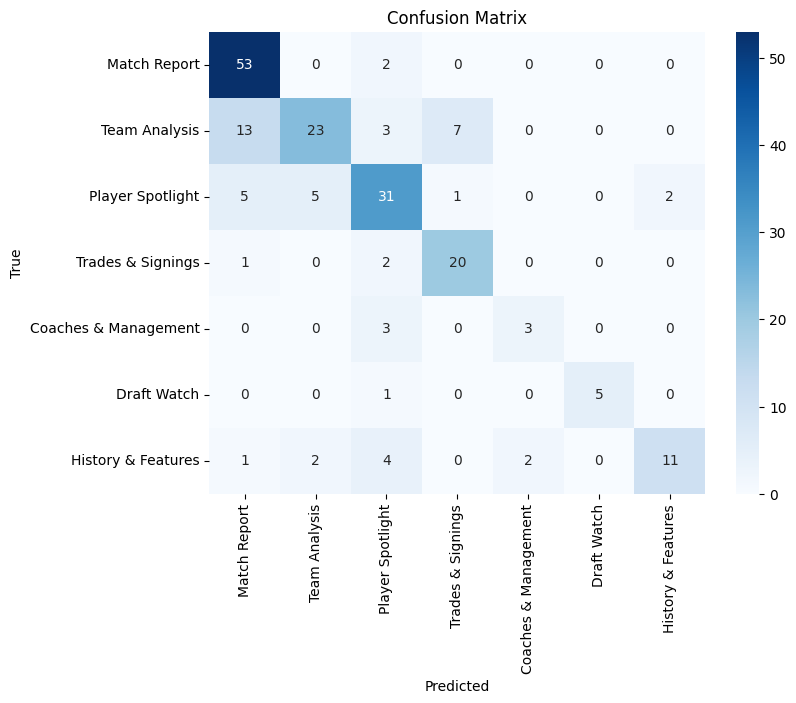

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
# 驗證集輸入
eval_dataset = encoded_test
predictions = trainer.predict(eval_dataset)

# 預測標籤與真實標籤
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 列印完整報表
print("Accuracy:", accuracy_score(labels, preds))
print("📄 分類報表 classification report：\n")
print(classification_report(
    labels,
    preds,
    target_names=label_names,
    labels=[0, 1, 2, 3, 4, 5, 6],
    digits=4,
    zero_division=0
))

# 混淆矩陣
cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3, 4, 5, 6])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Match Report", "Team Analysis", "Player Spotlight", "Trades & Signings", "Coaches & Management", "Draft Watch", "History & Features"], yticklabels=["Match Report", "Team Analysis", "Player Spotlight", "Trades & Signings", "Coaches & Management", "Draft Watch", "History & Features"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()